# PIGA
PIGA is one of several proteins required for the first step of GPI anchor biosynthesis.
[multiple congenital anomalies-hypotonia-seizures syndrome-2 (MCAHS2)](https://omim.org/entry/300868)
and
that neurodevelopmental disorder with epilepsy and hemochromatosis (NEDEPH)](https://omim.org/entry/301072) is caused by hemizygous mutation in the PIGA gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1


### PIGA
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for PIGA.

In [2]:
gene_symbol = 'PIGA'
mane_tx_id = 'NM_002641.4'
mane_protein_id = 'NP_002632.1' # phosphatidylinositol N-acetylglucosaminyltransferase subunit A isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.22') as ps:
        phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 27/27 [00:00<00:00, 444.20individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Global developmental delay,HP:0001263,12
Seizure,HP:0001250,10
Hypoplasia of the corpus callosum,HP:0002079,9
Hypsarrhythmia,HP:0002521,9
Flexion contracture,HP:0001371,8
Elevated circulating alkaline phosphatase concentration,HP:0003155,8
Generalized myoclonic seizure,HP:0002123,7
Cerebral visual impairment,HP:0100704,7
Abnormality of the face,HP:0000271,6
Hypotonia,HP:0001252,6


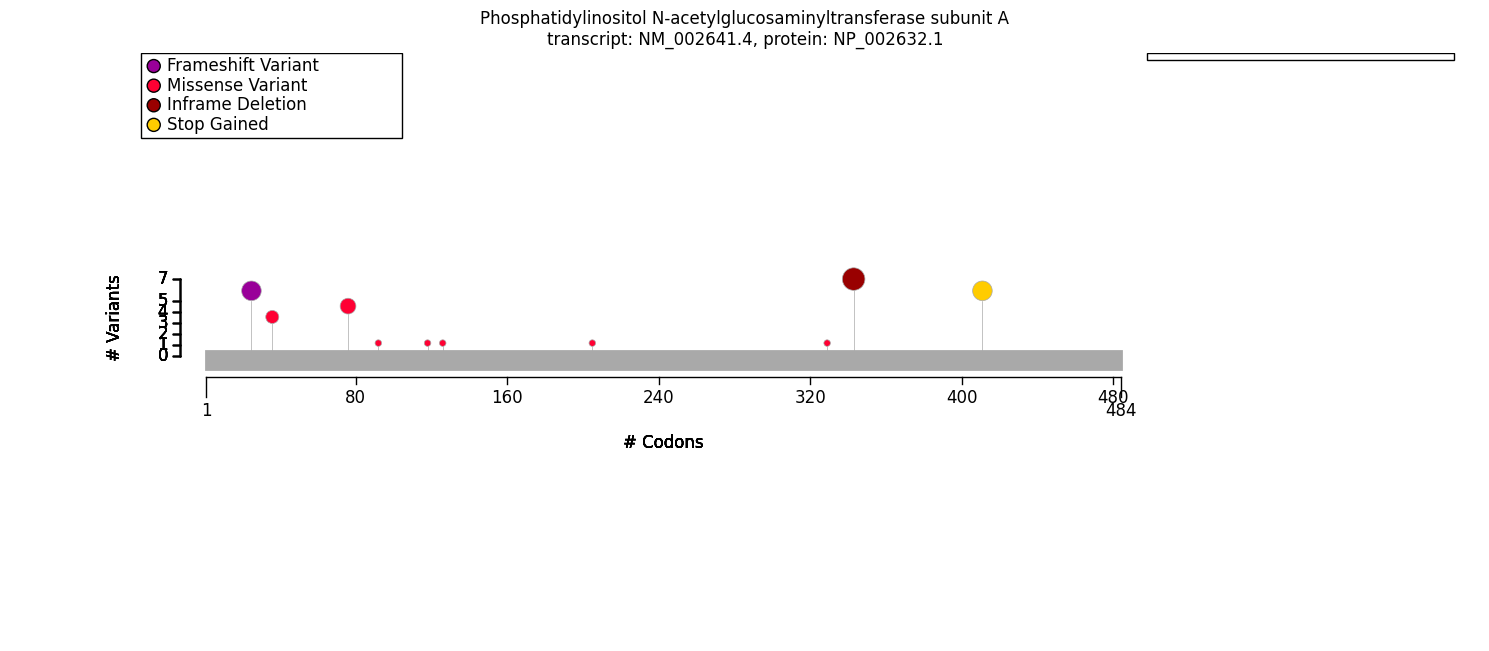

In [6]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

piga_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
piga_fig.tight_layout()

# Genotype Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

n_term = VariantPredicates.region(region=Region(0,200), tx_id=mane_tx_id)

n_term_predicate = monoallelic_predicate(a_predicate=n_term, 
                                         b_predicate=~ n_term, 
                                         a_label="1-100",
                                         b_label="100+")
n_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=n_term_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(n_term_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,14
HMF03,Skipping term because of a child term with the same individual counts,7
HMF08,Skipping general term,109
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,395


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=n_term_result)

Allele group                                        1-100           100+  \
                                                    Count Percent  Count   
Flexion contracture [HP:0001371]                      1/3     33%  10/12   
Hypotonia [HP:0001252]                                5/6     83%    7/7   
Hyperreflexia [HP:0001347]                            1/3     33%    6/9   
Abnormal cerebral white matter morphology [HP:0...    4/4    100%    7/7   
Abnormal cerebral morphology [HP:0002060]             5/5    100%  12/12   
Abnormal forebrain morphology [HP:0100547]            5/5    100%  12/12   
Abnormal brain morphology [HP:0012443]                5/5    100%  12/12   
Morphological central nervous system abnormalit...    5/5    100%  12/12   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       3/3    100%  11/11   
Aplasia/Hypoplasia involving the central nervou...    4/4    100%  12/12   
Motor seizure [HP:0020219]                            6/6    100%    6/6   
Seizure [HP:0001250]                                12/12    100%  13/13   
Joint contracture [HP:0034392]                        1/1    100%  10/10   
Abnormality of joint mobility [HP:0011729]            1/1    100%  10/10   
EEG with generalized epileptiform discharges [H...    9/9    100%    5/5   
Abnormal oral cavity morphology [HP:0000163]          1/1    100%  10/10   
Abnormal oral morphology [HP:0031816]                 1/1    100%  10/10   
Abnormal muscle tone [HP:0003808]                     6/6    100%  10/10   
Global developmental delay [HP:0001263]               8/8    100%    5/5   
Neurodevelopmental delay [HP:0012758]                 8/8    100%    7/7   
Neurodevelopmental abnormality [HP:0012759]         13/13    100%    9/9   
Spasticity [HP:0001257]                               3/5     60%    5/7   
Upper motor neuron dysfunction [HP:0002493]           4/4    100%    7/7   

Allele group                                                                   \
                                                   Percent Corrected p values   
Flexion contracture [HP:0001371]                       83%                1.0   
Hypotonia [HP:0001252]                                100%                1.0   
Hyperreflexia [HP:0001347]                             67%                1.0   
Abnormal cerebral white matter morphology [HP:0...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal forebrain morphology [HP:0100547]            100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Motor seizure [HP:0020219]                            100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Joint contracture [HP:0034392]                        100%                1.0   
Abnormality of joint mobility [HP:0011729]            100%                1.0   
EEG with generalized epileptiform discharges [H...    100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Abnormal oral morphology [HP:0031816]                 100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Spasticity [HP:0001257]                                71%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   

Allele group                                                  
          

In [10]:

l366del = VariantPredicates.variant_key("X_15324820_15324823_TAAG_T") # c.1030_1032del	p.Leu344del
l366del_predicate = monoallelic_predicate(a_predicate=l366del, 
                                         b_predicate=~ l366del, 
                                         a_label="p.Leu344del",
                                         b_label="other")
l366delresult = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=l366del_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=l366delresult)

Allele group                                       p.Leu344del          other  \
                                                         Count Percent  Count   
Spasticity [HP:0001257]                                    4/5     80%    4/7   
Abnormal cerebral morphology [HP:0002060]                  5/5    100%  12/12   
Abnormal forebrain morphology [HP:0100547]                 5/5    100%  12/12   
Abnormal brain morphology [HP:0012443]                     5/5    100%  12/12   
Morphological central nervous system abnormalit...         5/5    100%  12/12   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]            4/4    100%  10/10   
Aplasia/Hypoplasia involving the central nervou...         5/5    100%  11/11   
Seizure [HP:0001250]                                       6/6    100%  19/19   
Flexion contracture [HP:0001371]                           4/5     80%   7/10   
Joint contracture [HP:0034392]                             4/4    100%    7/7   
Abnormality of joint mobility [HP:0011729]                 4/4    100%    7/7   
Hyperreflexia [HP:0001347]                                 2/4     50%    5/8   
Abnormal oral cavity morphology [HP:0000163]               6/6    100%    5/5   
Abnormal oral morphology [HP:0031816]                      6/6    100%    5/5   
Hypotonia [HP:0001252]                                     4/4    100%    8/9   
Abnormal muscle tone [HP:0003808]                          6/6    100%  10/10   
Global developmental delay [HP:0001263]                    3/3    100%  10/10   
Neurodevelopmental delay [HP:0012758]                      4/4    100%  11/11   
Neurodevelopmental abnormality [HP:0012759]                4/4    100%  18/18   
Upper motor neuron dysfunction [HP:0002493]                5/5    100%    6/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Spasticity [HP:0001257]                                57%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal forebrain morphology [HP:0100547]            100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Flexion contracture [HP:0001371]                       70%                1.0   
Joint contracture [HP:0034392]                        100%                1.0   
Abnormality of joint mobility [HP:0011729]            100%                1.0   
Hyperreflexia [HP:0001347]                             62%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Abnormal oral morphology [HP:0031816]                 100%                1.0   
Hypotonia [HP:0001252]                                 89%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   

Allele group                                                  
                                                    p values  
Spasticity [HP:0001257]                             0.575758  
Abnormal cerebral morphology [HP:0002060]           1.000000  
Abnormal forebrain morphology [HP:0100547]          1.000000  
Abnormal brain morphology [HP:0012443]              1.000000  
Morphological central nervous system abnormalit...  1.00

In [11]:
from gpsea.model import VariantEffect
missense = VariantPredicates.variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = monoallelic_predicate(a_predicate=missense, 
                                         b_predicate=~missense, 
                                         a_label="missense",
                                         b_label="other")
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense          other  \
                                                      Count Percent  Count   
Flexion contracture [HP:0001371]                        2/5     40%   9/10   
Hyperreflexia [HP:0001347]                              1/4     25%    6/8   
Spasticity [HP:0001257]                                 4/7     57%    4/5   
Abnormal cerebral white matter morphology [HP:0...      5/5    100%    6/6   
Abnormal cerebral morphology [HP:0002060]               5/5    100%  12/12   
Abnormal forebrain morphology [HP:0100547]              5/5    100%  12/12   
Abnormal brain morphology [HP:0012443]                  5/5    100%  12/12   
Morphological central nervous system abnormalit...      5/5    100%  12/12   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]         5/5    100%    9/9   
Aplasia/Hypoplasia involving the central nervou...      5/5    100%  11/11   
Motor seizure [HP:0020219]                              5/5    100%    7/7   
Seizure [HP:0001250]                                  10/10    100%  15/15   
Joint contracture [HP:0034392]                          2/2    100%    9/9   
Abnormality of joint mobility [HP:0011729]              2/2    100%    9/9   
EEG with generalized epileptiform discharges [H...      6/6    100%    8/8   
Abnormal oral cavity morphology [HP:0000163]            3/3    100%    8/8   
Abnormal oral morphology [HP:0031816]                   3/3    100%    8/8   
Hypotonia [HP:0001252]                                  6/7     86%    6/6   
Abnormal muscle tone [HP:0003808]                       8/8    100%    8/8   
Global developmental delay [HP:0001263]                 5/5    100%    8/8   
Neurodevelopmental delay [HP:0012758]                   5/5    100%  10/10   
Neurodevelopmental abnormality [HP:0012759]           11/11    100%  11/11   
Upper motor neuron dysfunction [HP:0002493]             5/5    100%    6/6   

Allele group                                                                   \
                                                   Percent Corrected p values   
Flexion contracture [HP:0001371]                       90%                1.0   
Hyperreflexia [HP:0001347]                             75%                1.0   
Spasticity [HP:0001257]                                80%                1.0   
Abnormal cerebral white matter morphology [HP:0...    100%                1.0   
Abnormal cerebral morphology [HP:0002060]             100%                1.0   
Abnormal forebrain morphology [HP:0100547]            100%                1.0   
Abnormal brain morphology [HP:0012443]                100%                1.0   
Morphological central nervous system abnormalit...    100%                1.0   
Aplasia/Hypoplasia of the cerebrum [HP:0007364]       100%                1.0   
Aplasia/Hypoplasia involving the central nervou...    100%                1.0   
Motor seizure [HP:0020219]                            100%                1.0   
Seizure [HP:0001250]                                  100%                1.0   
Joint contracture [HP:0034392]                        100%                1.0   
Abnormality of joint mobility [HP:0011729]            100%                1.0   
EEG with generalized epileptiform discharges [H...    100%                1.0   
Abnormal oral cavity morphology [HP:0000163]          100%                1.0   
Abnormal oral morphology [HP:0031816]                 100%                1.0   
Hypotonia [HP:0001252]                                100%                1.0   
Abnormal muscle tone [HP:0003808]                     100%                1.0   
Global developmental delay [HP:0001263]               100%                1.0   
Neurodevelopmental delay [HP:0012758]                 100%                1.0   
Neurodevelopmental abnormality [HP:0012759]           100%                1.0   
Upper motor neuron dysfunction [HP:0002493]           100%                1.0   

Allele group           

# Summary

In [11]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


FET_results = (
   GPAnalysisResultSummary.from_multi(
        result=missense_result,
    
    ),
    GPAnalysisResultSummary.from_multi(
        result=l366delresult,
    ),
    GPAnalysisResultSummary.from_multi(
        result=n_term_result,
    ),

)


piga_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=FET_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=piga_caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense,other,23,0
Genotype (A),Genotype (B),Tests performed,Significant tests
p.Leu344del,other,20,0
Genotype (A),Genotype (B),Tests performed,Significant tests
1-100,100+,23,0


In [13]:
summarizer.process_latex(report=report, protein_fig=piga_fig)

Figure saved to ../../supplement/img/PIGA_protein_diagram-draft.pdf
Output to ../../supplement/tex/PIGA_summary_draft.tex
